
# CMU Movie Summary Corpus — Phase 1: Ingest, Clean, and Plot

**Dataset**: "Movie Summaries" (a.k.a. IMDb 5000 Movie Dataset)
URL: https://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz

Files we will use:
- `movie.metadata.tsv`  (tab-separated; includes movie name, date, **box office revenue**, runtime, languages, countries, genres)
- `plot_summaries.txt`  (optional; text plots, not needed for Phase 1)

**Today**
1) Download & extract the tar.gz
2) Read `movie.metadata.tsv` into pandas
3) Clean/transform: parse lists (genres/languages/countries), extract release year, cast revenue to numeric
4) Create **year-relative revenue tiers**: hit (top 25%), average (mid 50%), flop (bottom 25%)
5) Plots: revenue distribution (log10), top genres by count, hits by year


In [1]:

import os, tarfile, json, ast
from pathlib import Path
from urllib.request import urlretrieve

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 60)
pd.set_option("display.width", 140)

DATA_URL = "https://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz"
DATA_DIR = Path("/content/data/cmu_movie_summaries")
TAR_PATH  = DATA_DIR / "MovieSummaries.tar.gz"
EXTRACT_DIR = DATA_DIR / "MovieSummaries"

DATA_DIR.mkdir(parents=True, exist_ok=True)
print("Data dir:", DATA_DIR.resolve())


Data dir: /content/data/cmu_movie_summaries



## **Download & Extract**
If you're offline, upload `MovieSummaries.tar.gz` to `/content/data/cmu_movie_summaries/` and rerun extraction.


In [2]:

if not TAR_PATH.exists():
    print("Downloading MovieSummaries.tar.gz ...")
    urlretrieve(DATA_URL, TAR_PATH)
    print("Download complete.")
else:
    print("Archive already present; skipping download.")


Download complete.


In [ ]:
TAR_PATH="/content/data/cmu_movie_summaries/MovieSummaries.tar.gz"

In [3]:

EXTRACT_DIR.mkdir(parents=True, exist_ok=True)
with tarfile.open(TAR_PATH, "r:gz") as tf:
    tf.extractall(EXTRACT_DIR)
print("Extracted to:", EXTRACT_DIR)




/tmp/ipython-input-1355541551.py:3: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tf.extractall(EXTRACT_DIR)


Extracted to: /content/data/cmu_movie_summaries/MovieSummaries



## **Inspect files and read `movie.metadata.tsv`**
Column order (from dataset README/codebooks commonly used):
- 0: wikipedia_movie_id
- 1: freebase_id
- 2: movie_name
- 3: movie_release_date
- 4: movie_box_office_revenue
- 5: movie_runtime
- 6: movie_languages (JSON-like list of ["Language", weight])
- 7: movie_countries (JSON-like list)
- 8: movie_genres (JSON-like dict of {"FreebaseID": "GenreName"})





In [4]:

meta_path = next(EXTRACT_DIR.rglob("movie.metadata.tsv"))
plots_path = next(EXTRACT_DIR.rglob("plot_summaries.txt"))

print("metadata path:", meta_path)
print("plots path   :", plots_path)

colnames = [
    "wikipedia_movie_id","freebase_id","movie_name","movie_release_date",
    "movie_box_office_revenue","movie_runtime","movie_languages",
    "movie_countries","movie_genres"
]
meta = pd.read_csv(meta_path, sep="\t", header=None, names=colnames, dtype=str)

meta.head()


metadata path: /content/data/cmu_movie_summaries/MovieSummaries/MovieSummaries/movie.metadata.tsv
plots path   : /content/data/cmu_movie_summaries/MovieSummaries/MovieSummaries/plot_summaries.txt


,wikipedia_movie_id,freebase_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"



## **Clean & Transform**
- Parse `movie_box_office_revenue` → numeric (USD; may contain missing or zeros)
- Parse `movie_runtime` → numeric (minutes)
- Extract `release_year` from `movie_release_date`
- Parse JSON-like strings for languages, countries, genres
- Build `genres_list` (flat list)


In [5]:

def to_float(x):
    try:
        if x is None or x == "" or pd.isna(x): return np.nan
        return float(x)
    except Exception:
        return np.nan

def parse_jsonish(s):
    """Safely parse JSON-ish strings (dataset uses Python-literal style)."""
    if s is None or pd.isna(s) or s == "":
        return None
    try:
        return ast.literal_eval(s)
    except Exception:
        return None

def extract_year(date_str):
    if pd.isna(date_str) or not isinstance(date_str, str) or not date_str.strip():
        return np.nan
    # date formats vary; try last 4 digits or first 4 digits
    import re
    m = re.search(r"(\d{4})", date_str)
    return float(m.group(1)) if m else np.nan

meta["movie_box_office_revenue"] = meta["movie_box_office_revenue"].apply(to_float)
meta["movie_runtime"] = meta["movie_runtime"].apply(to_float)
meta["release_year"] = meta["movie_release_date"].apply(extract_year)

meta["languages_parsed"] = meta["movie_languages"].apply(parse_jsonish)
meta["countries_parsed"] = meta["movie_countries"].apply(parse_jsonish)
meta["genres_parsed"]    = meta["movie_genres"].apply(parse_jsonish)

# genres_parsed is a dict of {freebase_id: "GenreName"} → flatten to list of names
def genres_to_list(gdict):
    if isinstance(gdict, dict):
        return sorted(list(set(gdict.values())))
    return []

meta["genres_list"] = meta["genres_parsed"].apply(genres_to_list)

# quick peek
meta[["movie_name","release_year","movie_box_office_revenue","movie_runtime","genres_list"]].head()


,movie_name,release_year,movie_box_office_revenue,movie_runtime,genres_list
0,Ghosts of Mars,2001.0,14010832.0,98.0,"[Action, Adventure, Horror, Science Fiction, S..."
1,Getting Away with Murder: The JonBenét Ramsey ...,2000.0,NaN,95.0,"[Biographical film, Crime Drama, Drama, Mystery]"
2,Brun bitter,1988.0,NaN,83.0,"[Crime Fiction, Drama]"
3,White Of The Eye,1987.0,NaN,110.0,"[Erotic thriller, Psychological thriller, Thri..."
4,A Woman in Flames,1983.0,NaN,106.0,[Drama]


In [6]:
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81741 entries, 0 to 81740
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   wikipedia_movie_id        81741 non-null  object 
 1   freebase_id               81741 non-null  object 
 2   movie_name                81741 non-null  object 
 3   movie_release_date        74839 non-null  object 
 4   movie_box_office_revenue  8401 non-null   float64
 5   movie_runtime             61291 non-null  float64
 6   movie_languages           81741 non-null  object 
 7   movie_countries           81741 non-null  object 
 8   movie_genres              81741 non-null  object 
 9   release_year              74839 non-null  float64
 10  languages_parsed          81741 non-null  object 
 11  countries_parsed          81741 non-null  object 
 12  genres_parsed             81741 non-null  object 
 13  genres_list               81741 non-null  object 
dtypes: flo


##  **Label year-relative revenue tiers (Hit / Average / Flop)**
We use within-year percentiles to avoid inflation effects:
- Hit:    revenue >= 75th percentile of that year
- Average: between 25th and 75th
- Flop:   < 25th
Rows with missing/zero revenue get "unknown".


In [7]:
import numpy as np
import pandas as pd

# Assuming 'meta' is a DataFrame available in your environment
df = meta.copy()

# treat nonpositive or missing as NaN for tiering
df["valid_revenue"] = df["movie_box_office_revenue"].where(
    (meta["movie_box_office_revenue"].notna()) & (meta["movie_box_office_revenue"] > 0),
    np.nan
)

def label_within_year(group: pd.DataFrame) -> pd.Series:
    vals = group["valid_revenue"].dropna()

    # if too few films with revenue, mark unknown
    if len(vals) < 20:
        return pd.Series(["unknown"] * len(group), index=group.index)

    # Use 50th percentile (median) to split into two classes
    q50 = np.nanpercentile(vals, 50)

    def lab(v):
        if pd.isna(v):
            return "unknown" # Still 'unknown' if revenue is missing

        # Flop: revenue below the median
        if v < q50:
            return "flop"

        # Hit: revenue at or above the median
        return "hit"

    return group["valid_revenue"].apply(lab)

df["tier"] = (
    df.groupby(df["release_year"].astype("Int64"), group_keys=False)
      .apply(label_within_year)
)

df["tier"].value_counts(dropna=False)

,count
tier,
unknown,66866
NaN,6902
hit,4012
flop,3961



 ##  **Plots Distribution**, Top Genres, Hits per Year


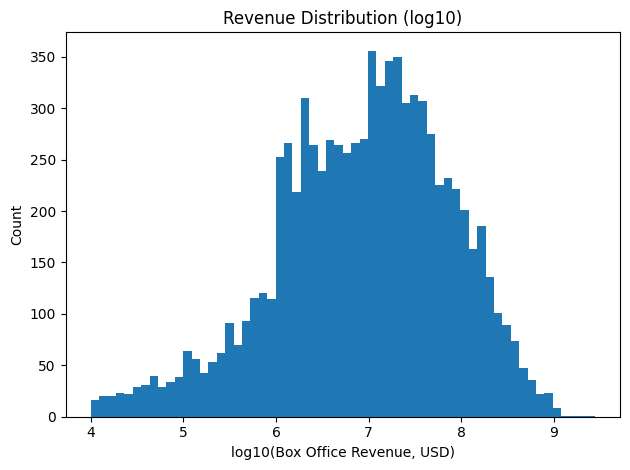

In [8]:
#  Revenue distribution (log10, valid only)
import matplotlib.pyplot as plt
rev = df["valid_revenue"].dropna()
plt.figure()
np.log10(rev[rev>0]).plot(kind="hist", bins=60)
plt.xlabel("log10(Box Office Revenue, USD)")
plt.ylabel("Count")
plt.title("Revenue Distribution (log10)")
plt.tight_layout()
plt.show()


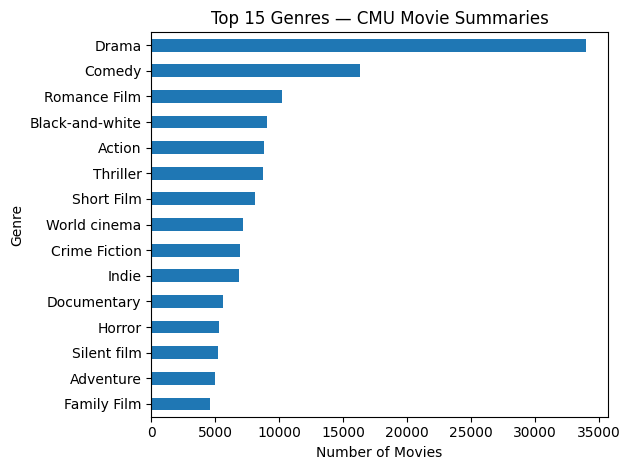

In [9]:
#  Top 15 genres by movie count
genres_exploded = df.explode("genres_list")
top_genres = (
    genres_exploded["genres_list"]
    .dropna()
    .value_counts()
    .head(15)
    .sort_values(ascending=True)
)
plt.figure()
top_genres.plot(kind="barh")
plt.xlabel("Number of Movies")
plt.ylabel("Genre")
plt.title("Top 15 Genres — CMU Movie Summaries")
plt.tight_layout()
plt.show()


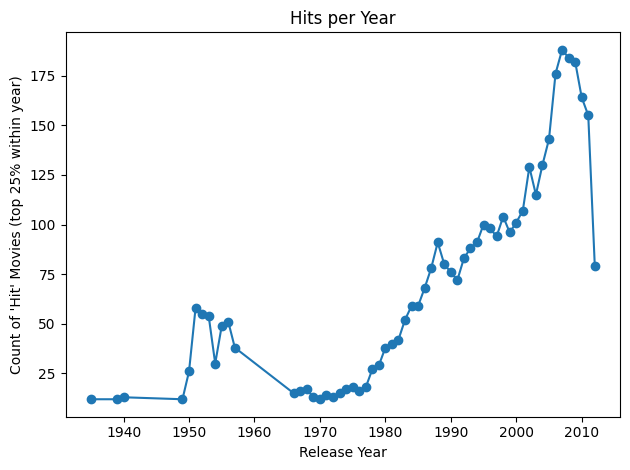

In [10]:
#  Number of 'hits' per year
hits_per_year = (
    df.loc[df["tier"]=="hit"]
      .groupby(df["release_year"].astype("Int64"))
      .size()
      .rename("hits")
      .sort_index()
)
plt.figure()
hits_per_year.plot(kind="line", marker="o")
plt.xlabel("Release Year")
plt.ylabel("Count of 'Hit' Movies (top 25% within year)")
plt.title("Hits per Year")
plt.tight_layout()
plt.show()


In [11]:
df

,wikipedia_movie_id,freebase_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,release_year,languages_parsed,countries_parsed,genres_parsed,genres_list,valid_revenue,tier
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...","[Action, Adventure, Horror, Science Fiction, S...",14010832.0,flop
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/02n4kr': 'Mystery', '/m/03bxz7': 'Biograp...","[Biographical film, Crime Drama, Drama, Mystery]",NaN,unknown
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988.0,{'/m/05f_3': 'Norwegian Language'},{'/m/05b4w': 'Norway'},"{'/m/0lsxr': 'Crime Fiction', '/m/07s9rl0': 'D...","[Crime Fiction, Drama]",NaN,unknown
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",1987.0,{'/m/02h40lc': 'English Language'},{'/m/07ssc': 'United Kingdom'},"{'/m/01jfsb': 'Thriller', '/m/0glj9q': 'Erotic...","[Erotic thriller, Psychological thriller, Thri...",NaN,unknown
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",1983.0,{'/m/04306rv': 'German Language'},{'/m/0345h': 'Germany'},{'/m/07s9rl0': 'Drama'},[Drama],NaN,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}",2011.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},{'/m/07s9rl0': 'Drama'},[Drama],NaN,unknown
81737,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0...",2011.0,{'/m/02h40lc': 'English Language'},"{'/m/03rt9': 'Ireland', '/m/07ssc': 'United Ki...","{'/m/03bxz7': 'Biographical film', '/m/07s9rl0...","[Biographical film, Documentary, Drama]",NaN,unknown
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}",1972.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/06nbt': 'Satire', '/m/01z4y': 'Comedy'}","[Comedy, Satire]",NaN,unknown
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ...",1992.0,{'/m/03_9r': 'Japanese Language'},{'/m/03_3d': 'Japan'},"{'/m/06n90': 'Science Fiction', '/m/0gw5n2f': ...","[Adventure, Animation, Anime, Drama, Japanese ...",NaN,unknown


In [12]:
# Filter out rows where 'tier' is 'unknown'
df_filtered = df[df["tier"] != "unknown"].copy()

# Filter out rows where 'tier' is NaN
# Note: df["tier"].dropna() would also work, but this explicit check is often clearer.
df_filtered = df_filtered[df_filtered["tier"].notna()].copy()

# The resulting dataframe 'df_filtered' now only contains 'hit' and 'flop' tiers.

# To verify the result:
df_filtered["tier"].value_counts(dropna=False)

,count
tier,
hit,4012
flop,3961


In [13]:

# 2. Define Target
y = df_filtered["tier"]

# 3. Define Features (X) by dropping columns
# We drop IDs, Targets, Raw Data, and Intermediate columns
cols_to_drop = [
    # Targets / Leaks
    "tier", "movie_box_office_revenue", "valid_revenue",

    # IDs
    "wikipedia_movie_id", "freebase_id", "movie_name",

    # Raw JSON Strings
    "movie_release_date", "movie_languages", "movie_countries", "movie_genres",

    # Intermediate / Parsed Structures
    "languages_parsed", "countries_parsed", "genres_parsed", "genres_list"
]

# Ensure we only drop columns that actually exist in the dataframe
existing_cols_to_drop = [c for c in cols_to_drop if c in df_filtered.columns]
X = df_filtered.drop(columns=existing_cols_to_drop)

# 4. Final Sanity Check
print("Target shape:", y.shape)
print("Features shape:", X.shape)
print("\nFinal Feature List:\n", X.columns.tolist())

Target shape: (7973,)
Features shape: (7973, 2)

Final Feature List:
 ['movie_runtime', 'release_year']


In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder



# ---------------------------------------------------------
# 2. ENCODE TARGET (y)
# ---------------------------------------------------------
# Convert 'flop', 'average', 'hit' -> 0, 1, 2
le = LabelEncoder()
y = le.fit_transform(df_filtered["tier"])

# Print the mapping so you know which number is which
print("\nTarget Mapping:")
for i, class_name in enumerate(le.classes_):
    print(f"  {i}: {class_name}")

# ---------------------------------------------------------
# 3. FEATURE ENGINEERING & ENCODING (X)
# ---------------------------------------------------------

# A. Handle GENRES (Multi-Label One-Hot Encoding)
# Each movie can have multiple genres. We create a column for each genre (g_Action, g_Comedy...)
mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(df_filtered["genres_list"])
# Create a DataFrame with these new columns
genres_df = pd.DataFrame(
    genres_encoded,
    columns=[f"g_{c}" for c in mlb.classes_],
    index=df_filtered.index
)

# B. Handle COUNTRIES & LANGUAGES (Extract Boolean Flags)
# Instead of encoding every single country (too many), we capture the dominant market power.

# Helper function to check if US is in the countries dictionary
def check_us(countries):
    if not isinstance(countries, dict): return 0
    return 1 if "United States of America" in countries.values() else 0

# Helper function to check if English is in the languages dictionary
def check_english(langs):
    if not isinstance(langs, dict): return 0
    return 1 if "English Language" in langs.values() else 0

df_filtered["is_US"] = df_filtered["countries_parsed"].apply(check_us)
df_filtered["is_English"] = df_filtered["languages_parsed"].apply(check_english)

# C. Handle DATES (Extract Seasonality)
# Convert to month number (1-12) to capture seasonal trends (Summer vs. Winter)
df_filtered["release_month"] = pd.to_datetime(df_filtered["movie_release_date"], errors='coerce').dt.month.fillna(0).astype(int)

# ---------------------------------------------------------
# 4. ASSEMBLE FINAL FEATURE SET
# ---------------------------------------------------------

# Select the numeric columns we want to keep
numeric_cols = ["movie_runtime", "release_year", "release_month", "is_US", "is_English"]

# Concatenate: Numeric Features + Genre Features
X = pd.concat([df_filtered[numeric_cols], genres_df], axis=1)

# ---------------------------------------------------------
# 5. FINAL CHECK
# ---------------------------------------------------------
print("\n--- Encoding Complete ---")
print(f"Features (X) Shape: {X.shape}")
print(f"Target (y) Shape:   {y.shape}")

# Show the first few columns to verify
print("\nFirst 5 rows of X:")
print(X.iloc[:5, :10]) # Printing only first 10 columns for readability


Target Mapping:
  0: flop
  1: hit

--- Encoding Complete ---
Features (X) Shape: (7973, 312)
Target (y) Shape:   (7973,)

First 5 rows of X:
    movie_runtime  release_year  release_month  is_US  is_English  g_Absurdism  g_Acid western  g_Action  g_Action Comedy  \
0            98.0        2001.0              8      1           1            0               0         1                0   
13          137.0        1989.0             11      0           1            0               0         0                0   
21           92.0        1999.0             10      1           1            0               0         0                0   
29          123.0        2001.0              6      1           1            0               0         0                0   
36           96.0        1940.0              0      1           1            0               0         0                0   

    g_Action Thrillers  
0                    0  
13                   0  
21                   0  
29    

In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder

import re # Import re for regular expressions

# Sanitize feature names for XGBoost compatibility
def sanitize_feature_name(name):
    # Replace characters that are not alphanumeric or underscore with an underscore
    name = str(name) # Ensure name is a string
    name = re.sub(r'[^a-zA-Z0-9_]', '_', name)
    # Replace multiple underscores with a single one
    name = re.sub(r'__+', '_', name)
    # Remove leading/trailing underscores if any
    return name.strip('_')

# Helper functions for Market Dominance (copied from hwUCxrzWVVCP for self-containment)
def check_us(countries):
    if not isinstance(countries, dict): return 0
    return 1 if "United States of America" in countries.values() else 0
def check_english(langs):
    if not isinstance(langs, dict): return 0
    return 1 if "English Language" in langs.values() else 0

# --- RE-INITIALIZE clean_df to ensure 'tier' is present ---
# This logic is consolidated from hwUCxrzWVVCP to make this cell self-contained.
clean_df = df[
    (df["tier"] != "unknown") &
    (df["movie_runtime"].notna()) &
    (df["release_year"].notna())
].copy()

clean_df["is_US"] = clean_df["countries_parsed"].apply(check_us)
clean_df["is_English"] = clean_df["languages_parsed"].apply(check_english)
clean_df["release_month"] = pd.to_datetime(clean_df["movie_release_date"], errors='coerce').dt.month.fillna(0).astype(int)


# 1. ENCODE TARGET
# We store the encoded target directly in clean_df as 'target'
le = LabelEncoder()
clean_df["target"] = le.fit_transform(clean_df["tier"])

print("Target Classes mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

# 2. ENCODE GENRES (One-Hot)
mlb = MultiLabelBinarizer()
genres_dummies = pd.DataFrame(
    mlb.fit_transform(clean_df["genres_list"]),
    # Apply sanitization to genre names for column headers
    columns=[f"g_{sanitize_feature_name(c)}" for c in mlb.classes_],
    index=clean_df.index
)

# 3. SELECT NUMERIC FEATURES
numeric_features = clean_df[[
    "movie_runtime",
    "release_year",
    "release_month",
    "is_US",
    "is_English",
    "target" # Keep target in the dataframe for now
]]

# 4. OVERWRITE clean_df
# We merge the numeric features with the genre dummy columns
clean_df = pd.concat([numeric_features, genres_dummies], axis=1)

# Sanitize all column names in the final clean_df for robustness
clean_df.columns = [sanitize_feature_name(col) for col in clean_df.columns]

print(f"Updated clean_df Shape: {clean_df.shape}")
print("clean_df is now ready for ML (all numeric).")

# 5. DEFINE X AND y FROM THE UPDATED DATAFRAME
X = clean_df.drop(columns=["target"])
y = clean_df["target"]

print(f"Final ML Shapes | X: {X.shape}, y: {y.shape}")

Target Classes mapping: {'flop': np.int64(0), 'hit': np.int64(1)}
Updated clean_df Shape: (7900, 313)
clean_df is now ready for ML (all numeric).
Final ML Shapes | X: (7900, 312), y: (7900,)


In [ ]:
clean_df.head()

,movie_runtime,release_year,release_month,is_US,is_English,target,g_Absurdism,g_Acid_western,g_Action,g_Action_Comedy,g_Action_Thrillers,g_Action_Adventure,g_Addiction_Drama,g_Adult,g_Adventure,g_Adventure_Comedy,g_Airplanes_and_airports,g_Albino_bias,g_Alien_Film,g_Alien_invasion,g_Americana,g_Animal_Picture,g_Animals,g_Animated_Musical,g_Animated_cartoon,g_Animation,g_Anime,g_Anthology,g_Anthropology,g_Anti_war,...,g_Superhero_movie,g_Supermarionation,g_Supernatural,g_Surrealism,g_Suspense,g_Swashbuckler_films,g_Sword_and_Sandal,g_Sword_and_sorcery,g_Sword_and_sorcery_films,g_Tamil_cinema,g_Teen,g_Television_movie,g_The_Netherlands_in_World_War_II,g_Therimin_music,g_Thriller,g_Time_travel,g_Tragedy,g_Tragicomedy,g_Travel,g_Vampire_movies,g_War_film,g_Werewolf_fiction,g_Western,g_Whodunit,g_Women_in_prison_films,g_Workplace_Comedy,g_World_History,g_World_cinema,g_Wuxia,g_Zombie_Film
0,98.0,2001.0,8,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13,137.0,1989.0,11,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
21,92.0,1999.0,10,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
29,123.0,2001.0,6,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
36,96.0,1940.0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


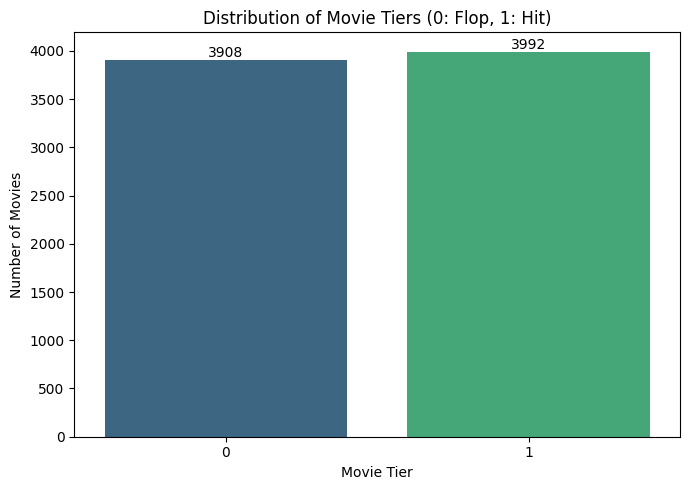

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
ax = sns.countplot(x=clean_df["target"], palette="viridis")

# Add title and labels
plt.title("Distribution of Movie Tiers (0: Flop, 1: Hit)")
plt.xlabel("Movie Tier")
plt.ylabel("Number of Movies")

# Add counts on top of the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f')

plt.tight_layout()
plt.show()

# **Machine Learnning Model**

## **Data Splitting**

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix


# Split: 80% Train, 20% Test (Stratified to keep class ratios consistent)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training on {X_train.shape[0]} samples, Testing on {X_test.shape[0]} samples.")

Training on 6320 samples, Testing on 1580 samples.


## **Model Defination**


EVALUATING: Logistic Regression

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

        flop       0.72      0.66      0.69       782
         hit       0.69      0.75      0.72       798

    accuracy                           0.71      1580
   macro avg       0.71      0.70      0.70      1580
weighted avg       0.71      0.71      0.70      1580



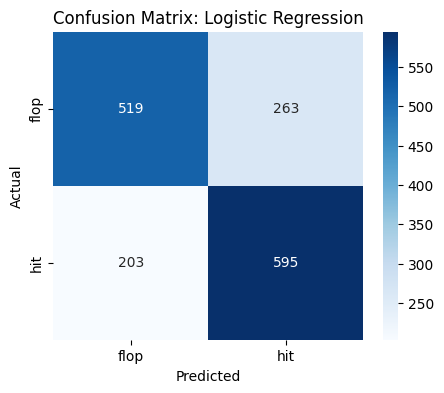


EVALUATING: Random Forest

Classification Report for Random Forest:
              precision    recall  f1-score   support

        flop       0.73      0.66      0.69       782
         hit       0.69      0.76      0.72       798

    accuracy                           0.71      1580
   macro avg       0.71      0.71      0.71      1580
weighted avg       0.71      0.71      0.71      1580



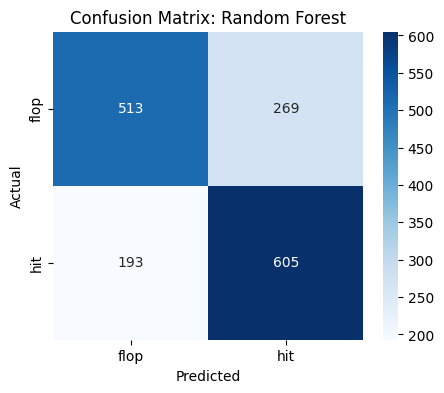


EVALUATING: XGBoost

Classification Report for XGBoost:
              precision    recall  f1-score   support

        flop       0.73      0.68      0.70       782
         hit       0.70      0.75      0.73       798

    accuracy                           0.71      1580
   macro avg       0.71      0.71      0.71      1580
weighted avg       0.71      0.71      0.71      1580



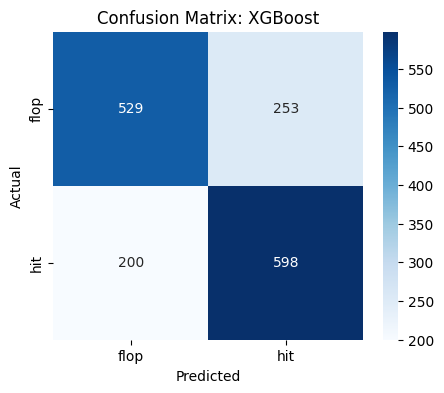


GENERATING COMBINED ROC CURVE


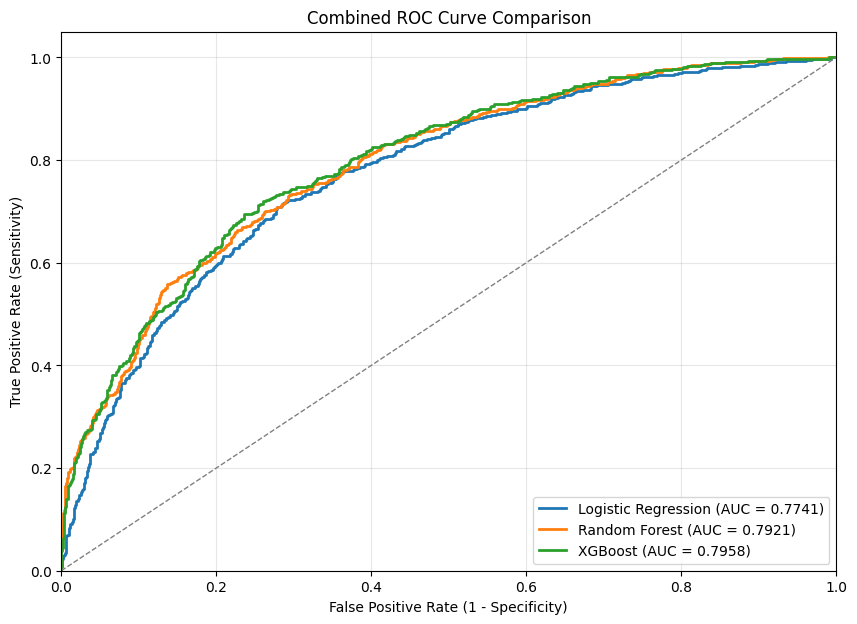


FINAL PERFORMANCE SUMMARY TABLE
              Model  Accuracy  Balanced Acc  ROC Accuracy  Precision   Recall  F1 Score  Train Time (s)
            XGBoost  0.713291      0.712922      0.795784   0.702703 0.749373  0.725288          1.6283
      Random Forest  0.707595      0.707078      0.792058   0.692220 0.758145  0.723684          1.6743
Logistic Regression  0.705063      0.704648      0.774136   0.693473 0.745614  0.718599         64.6503


In [21]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_score,
    recall_score, f1_score, classification_report,
    confusion_matrix, roc_curve, auc, roc_auc_score
)

# 1. Suppress warnings
warnings.filterwarnings('ignore')

# --- 2. DEFINE MODELS ---
models = {
    "Logistic Regression": LogisticRegression(max_iter=5000, class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=150, max_depth=15, class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(n_estimators=150, max_depth=6, learning_rate=0.1, random_state=42, use_label_encoder=False, eval_metric='logloss')
}

results = []
trained_models = {}
roc_data = {} # To store data for the final combined plot

for name, clf in models.items():
    print(f"\n{'='*40}")
    print(f"EVALUATING: {name}")
    print(f"{'='*40}")

    # --- Training ---
    start_train = time.time()
    clf.fit(X_train, y_train)
    train_time = time.time() - start_train
    trained_models[name] = clf

    # --- Prediction ---
    start_test = time.time()
    y_pred = clf.predict(X_test)
    test_time = time.time() - start_test

    # --- Metric Calculation ---
    acc = accuracy_score(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # ROC AUC Calculation
    if hasattr(clf, "predict_proba"):
        y_score = clf.predict_proba(X_test)[:, 1]
    else:
        y_score = clf.decision_function(X_test)

    roc_auc_val = roc_auc_score(y_test, y_score)

    # Store ROC curve points for final plot
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_data[name] = (fpr, tpr, roc_auc_val)

    # Append to results list
    results.append({
        "Model": name,
        "Accuracy": acc,
        "Balanced Acc": bal_acc,
        "ROC Accuracy": roc_auc_val,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1,
        "Train Time (s)": round(train_time, 4)
    })

    # --- A. SHOW INDIVIDUAL CLASSIFICATION REPORT ---
    target_names = [str(c) for c in le.classes_]
    print(f"\nClassification Report for {name}:")
    print(classification_report(y_test, y_pred, target_names=target_names))

    # --- B. SHOW INDIVIDUAL CONFUSION MATRIX ---
    plt.figure(figsize=(5, 4))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# --- 3. COMBINED ROC CURVE PLOT ---
print(f"\n{'='*40}\nGENERATING COMBINED ROC CURVE\n{'='*40}")
plt.figure(figsize=(10, 7))
for name, (fpr, tpr, score) in roc_data.items():
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {score:.4f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Combined ROC Curve Comparison')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


# --- 4. FINAL SUMMARY DATAFRAME ---
print(f"\n{'='*40}\nFINAL PERFORMANCE SUMMARY TABLE\n{'='*40}")
results_df = pd.DataFrame(results)
# Sort by ROC Accuracy to see the most robust model at the top
results_df = results_df.sort_values(by="ROC Accuracy", ascending=False).reset_index(drop=True)

# Display the final table
print(results_df.to_string(index=False))

# Optional: Display as a stylized dataframe if in a Jupyter/Colab environment
# display(results_df)


Tuning & Evaluating: Logistic Regression
Best Params found: {'C': 0.1, 'solver': 'liblinear'}

Classification Report:
              precision    recall  f1-score   support

        flop       0.72      0.67      0.69       782
         hit       0.70      0.74      0.72       798

    accuracy                           0.71      1580
   macro avg       0.71      0.71      0.71      1580
weighted avg       0.71      0.71      0.71      1580



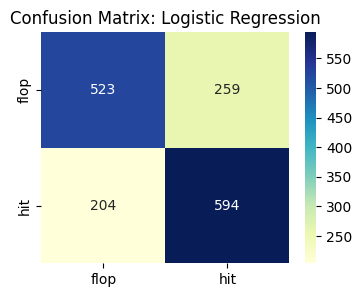


Tuning & Evaluating: Random Forest
Best Params found: {'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 150}

Classification Report:
              precision    recall  f1-score   support

        flop       0.73      0.66      0.69       782
         hit       0.69      0.76      0.72       798

    accuracy                           0.71      1580
   macro avg       0.71      0.71      0.71      1580
weighted avg       0.71      0.71      0.71      1580



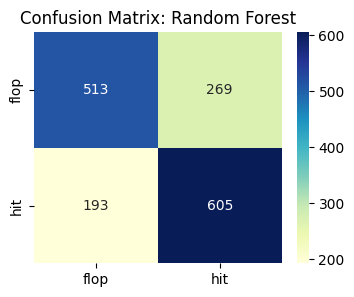


Tuning & Evaluating: XGBoost
Best Params found: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200}

Classification Report:
              precision    recall  f1-score   support

        flop       0.73      0.68      0.70       782
         hit       0.70      0.75      0.73       798

    accuracy                           0.71      1580
   macro avg       0.71      0.71      0.71      1580
weighted avg       0.71      0.71      0.71      1580



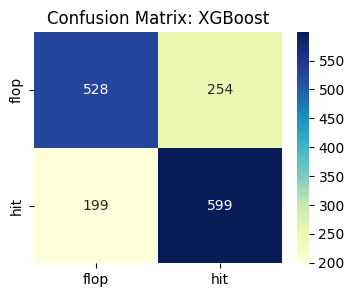


FINAL COMBINED ROC CURVE (POST-TUNING)


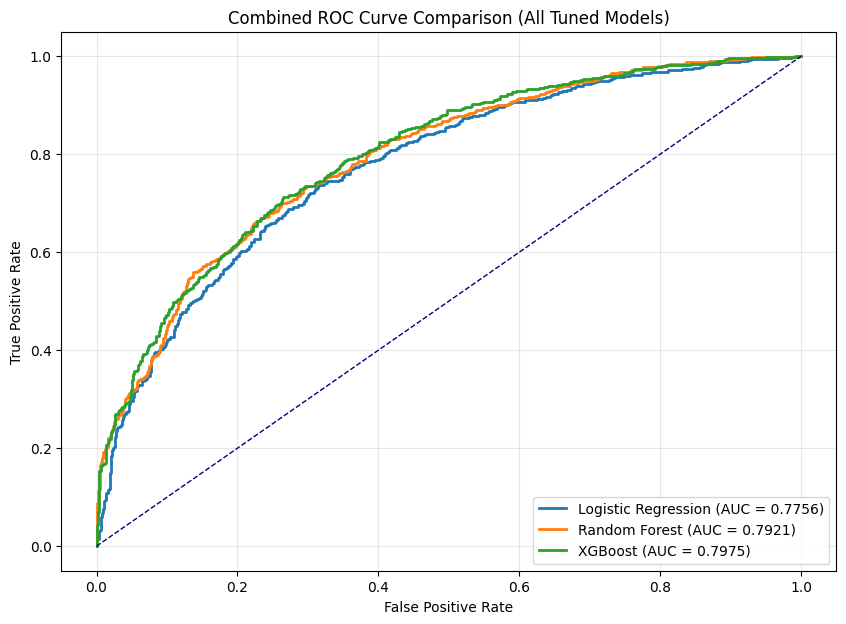


FINAL PERFORMANCE SUMMARY TABLE
              Model                                                Best Parameters  Accuracy  Precision  ROC Accuracy  F1 Score  Train Time (s)  Test Time (s)
            XGBoost    {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200}    0.7133     0.7022        0.7975    0.7256         26.0960         0.0410
      Random Forest {'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 150}    0.7076     0.6922        0.7921    0.7237         52.1828         0.0465
Logistic Regression                              {'C': 0.1, 'solver': 'liblinear'}    0.7070     0.6964        0.7756    0.7196        102.6723         0.0097


In [24]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_score,
    recall_score, f1_score, classification_report,
    confusion_matrix, roc_curve, auc, roc_auc_score
)

warnings.filterwarnings('ignore')

# --- 1. DEFINE PARAMETER GRIDS ---
param_grids = {
    "Logistic Regression": {
        'C': [0.1, 1, 10],
        'solver': ['lbfgs', 'liblinear']
    },
    "Random Forest": {
        'n_estimators': [100, 150, 200],
        'max_depth': [10, 15, 20],
        'min_samples_split': [2, 5]
    },
    "XGBoost": {
        'n_estimators': [100, 150, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [4, 6]
    }
}

base_models = {
    "Logistic Regression": LogisticRegression(max_iter=5000, class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

results = []
roc_data = {}

# --- 2. TUNING & EVALUATION LOOP ---
for name in base_models.keys():
    print(f"\n{'='*60}")
    print(f"Tuning & Evaluating: {name}")
    print(f"{'='*60}")

    # Initialize GridSearchCV optimizing for Accuracy
    grid_search = GridSearchCV(
        estimator=base_models[name],
        param_grid=param_grids[name],
        cv=3,
        scoring='accuracy',
        n_jobs=-1
    )

    # --- Tuning/Training Time ---
    start_train = time.time()
    grid_search.fit(X_train, y_train)
    train_time = time.time() - start_train

    best_clf = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # --- Prediction/Testing Time ---
    start_test = time.time()
    y_pred = best_clf.predict(X_test)
    test_time = time.time() - start_test

    # --- Metrics ---
    acc = accuracy_score(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # ROC AUC Calculation
    if hasattr(best_clf, "predict_proba"):
        y_score = best_clf.predict_proba(X_test)[:, 1]
    else:
        y_score = best_clf.decision_function(X_test)

    roc_auc_val = roc_auc_score(y_test, y_score)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_data[name] = (fpr, tpr, roc_auc_val)

    # Append all requested data to results
    results.append({
        "Model": name,
        "Best Parameters": str(best_params), # Stored as string for table display
        "Accuracy": round(acc, 4),
        "Precision": round(prec, 4),
        "ROC Accuracy": round(roc_auc_val, 4),
        "F1 Score": round(f1, 4),
        "Train Time (s)": round(train_time, 4),
        "Test Time (s)": round(test_time, 4)
    })

    # Individual Model Report
    target_names = [str(c) for c in le.classes_]
    print(f"Best Params found: {best_params}")
    print(f"\nClassification Report:\n{classification_report(y_test, y_pred, target_names=target_names)}")

    # Confusion Matrix
    plt.figure(figsize=(4, 3))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=target_names, yticklabels=target_names)
    plt.title(f"Confusion Matrix: {name}")
    plt.show()

# --- 3. FINAL COMBINED ROC CURVE ---
print(f"\n{'='*60}\nFINAL COMBINED ROC CURVE (POST-TUNING)\n{'='*60}")
plt.figure(figsize=(10, 7))
for name, (fpr, tpr, score) in roc_data.items():
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {score:.4f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Combined ROC Curve Comparison (All Tuned Models)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# --- 4. FINAL SUMMARY DATAFRAME ---
print(f"\n{'='*60}\nFINAL PERFORMANCE SUMMARY TABLE\n{'='*60}")
results_df = pd.DataFrame(results).sort_values(by="ROC Accuracy", ascending=False)

# Using to_string to ensure the Best Parameters column isn't truncated in console
print(results_df.to_string(index=False))


PERFORMING 10-FOLD CROSS-VALIDATION
Validating XGBoost...
Validating Random Forest...
Validating Logistic Regression...

K-FOLD CROSS-VALIDATION SUMMARY
              Model  CV Mean Accuracy  CV Std Dev (±)  Best Fold  Worst Fold
            XGBoost            0.7319          0.0178     0.7570      0.6924
      Random Forest            0.7268          0.0161     0.7468      0.6949
Logistic Regression            0.7161          0.0143     0.7380      0.6911


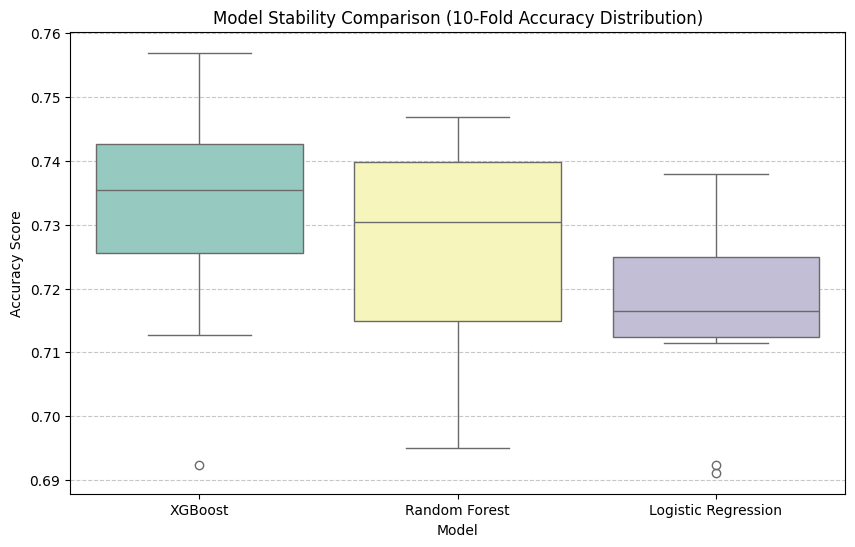

In [25]:
import numpy as np
from sklearn.model_selection import cross_val_score, KFold

# --- 1. SETUP MODELS WITH BEST PARAMETERS ---
# Based on your results table, we initialize the models with their optimal settings
optimized_models = {
    "XGBoost": XGBClassifier(
        learning_rate=0.1, max_depth=4, n_estimators=200,
        random_state=42, use_label_encoder=False, eval_metric='logloss'
    ),
    "Random Forest": RandomForestClassifier(
        max_depth=15, min_samples_split=2, n_estimators=150,
        class_weight='balanced', random_state=42
    ),
    "Logistic Regression": LogisticRegression(
        C=0.1, solver='liblinear', max_iter=5000,
        class_weight='balanced', random_state=42
    )
}

# --- 2. APPLY K-FOLD CROSS-VALIDATION ---
kf_results = []
k_folds = 10
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

print(f"\n{'='*60}")
print(f"PERFORMING {k_folds}-FOLD CROSS-VALIDATION")
print(f"{'='*60}")

for name, model in optimized_models.items():
    print(f"Validating {name}...")

    # Calculate Cross-Validation Scores
    # We use X (entire feature set) and y (entire target set)
    cv_scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy', n_jobs=-1)

    mean_score = cv_scores.mean()
    std_score = cv_scores.std()

    kf_results.append({
        "Model": name,
        "CV Mean Accuracy": round(mean_score, 4),
        "CV Std Dev (±)": round(std_score, 4),
        "Best Fold": round(cv_scores.max(), 4),
        "Worst Fold": round(cv_scores.min(), 4)
    })

# --- 3. SUMMARY DATAFRAME ---
kf_df = pd.DataFrame(kf_results).sort_values(by="CV Mean Accuracy", ascending=False)
print(f"\n{'='*60}")
print("K-FOLD CROSS-VALIDATION SUMMARY")
print(f"{'='*60}")
print(kf_df.to_string(index=False))

# --- 4. VISUALIZATION ---
plt.figure(figsize=(10, 6))
sns.boxplot(data=pd.DataFrame({name: cross_val_score(model, X, y, cv=kf)
                              for name, model in optimized_models.items()}),
            palette="Set3")
plt.title(f"Model Stability Comparison ({k_folds}-Fold Accuracy Distribution)")
plt.ylabel("Accuracy Score")
plt.xlabel("Model")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Generating SHAP Summary Plot...


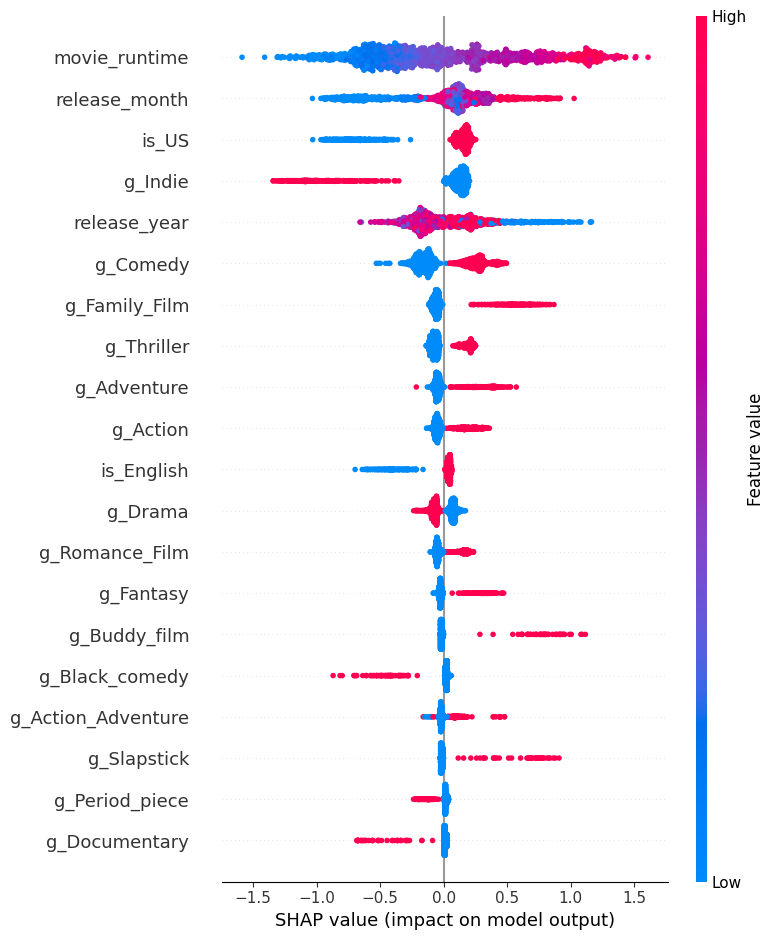

Generating SHAP Bar Plot...


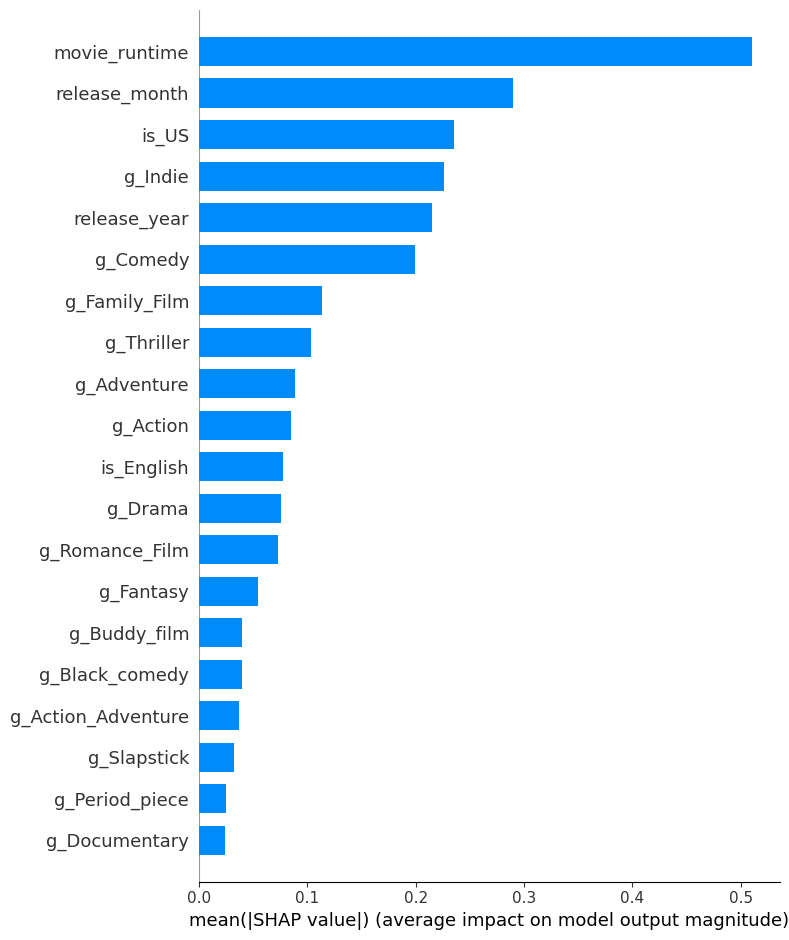


Generating Waterfall Plot for the first prediction...


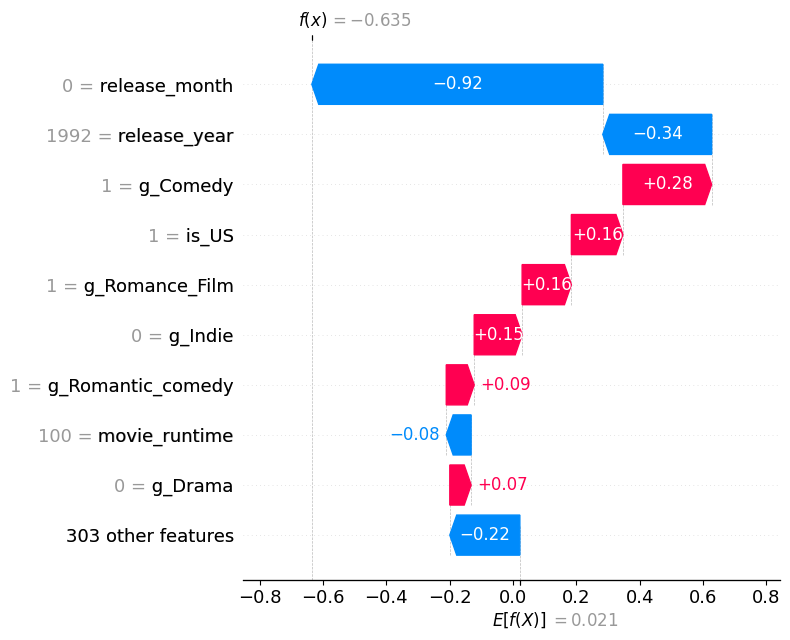

In [27]:
import shap
import matplotlib.pyplot as plt

# 1. Initialize the SHAP Explainer
# We use the best XGBoost model found during your tuning
best_xgb = optimized_models["XGBoost"]

# FIX: Fit the best_xgb model before passing it to SHAP explainer
best_xgb.fit(X_train, y_train)

# SHAP works best when it can 'see' the model's logic
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_test)

# --- A. GLOBAL IMPORTANCE (Summary Plot) ---
# This shows the impact of every feature across all test samples
print("\nGenerating SHAP Summary Plot...")
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, feature_names=X.columns, show=False) # Added show=False to prevent immediate display
plt.tight_layout()
plt.show()

# --- B. GLOBAL IMPORTANCE (Bar Plot) ---
# This shows the average absolute impact (magnitude) of each feature
print("Generating SHAP Bar Plot...")
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=X.columns, show=False) # Added show=False
plt.tight_layout()
plt.show()

# --- C. LOCAL EXPLANATION (Individual Movie Prediction) ---
# Let's look at the first movie in the test set (index 0)
# This explains: "Why did the model give this specific result?"
print("\nGenerating Waterfall Plot for the first prediction...")
plt.figure(figsize=(8, 4))
# We use .base_values and .values for the latest SHAP API
explanation = shap.Explanation(
    values=shap_values[0],
    base_values=explainer.expected_value,
    data=X_test.iloc[0],
    feature_names=X.columns
)
shap.plots.waterfall(explanation, show=False) # Added show=False
plt.tight_layout()
plt.show()